In [ ]:
# Loan Default Prediction - Model Build

In [ ]:
!pip install xgboost onnxmltools onnx scikit-learn skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.5/352.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 21.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score
from xgboost import XGBClassifier
import joblib
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType
import onnx

In [17]:
# STEP 1: Load Dataset
df = pd.read_csv('/content/Loan_default_Selected_8_features.csv')
df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,InterestRate,DTIRatio,LoanTerm,Default
0,56,85994,50587,520,80,15.23,0.44,36,0
1,69,50432,124440,458,15,4.81,0.68,60,0
2,46,84208,129188,451,26,21.17,0.31,24,1
3,32,31713,44799,743,0,7.07,0.23,24,0
4,60,20437,9139,633,8,6.51,0.73,48,0


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
print("Basic Information:")
print(df.info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451388 entries, 0 to 451387
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Age             451388 non-null  int64  
 1   Income          451388 non-null  int64  
 2   LoanAmount      451388 non-null  int64  
 3   CreditScore     451388 non-null  int64  
 4   MonthsEmployed  451388 non-null  int64  
 5   InterestRate    451388 non-null  float64
 6   DTIRatio        451388 non-null  float64
 7   LoanTerm        451388 non-null  int64  
 8   Default         451388 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.0 MB
None


In [20]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
                 Age         Income     LoanAmount    CreditScore  \
count  451388.000000  451388.000000  451388.000000  451388.000000   
mean       40.260246   77862.804118  134980.037655     567.343106   
std        14.018020   40112.412443   70749.099081     147.146102   
min        18.000000   15000.000000    5000.000000     300.000000   
25%        28.000000   41751.000000   74859.000000     445.000000   
50%        39.000000   76215.000000  138665.000000     564.000000   
75%        51.000000  112631.000000  197471.000000     687.000000   
max        69.000000  149999.000000  249999.000000     849.000000   

       MonthsEmployed   InterestRate       DTIRatio       LoanTerm  \
count   451388.000000  451388.000000  451388.000000  451388.000000   
mean        55.261323      14.535316       0.505602      35.881483   
std         32.154118       6.153289       0.213011      15.706709   
min          0.000000       2.000000       0.100000      12.000000   
25%    

In [21]:
print("\nClass Distribution:")
print(df['Default'].value_counts())


Class Distribution:
Default
0    225694
1    225694
Name: count, dtype: int64


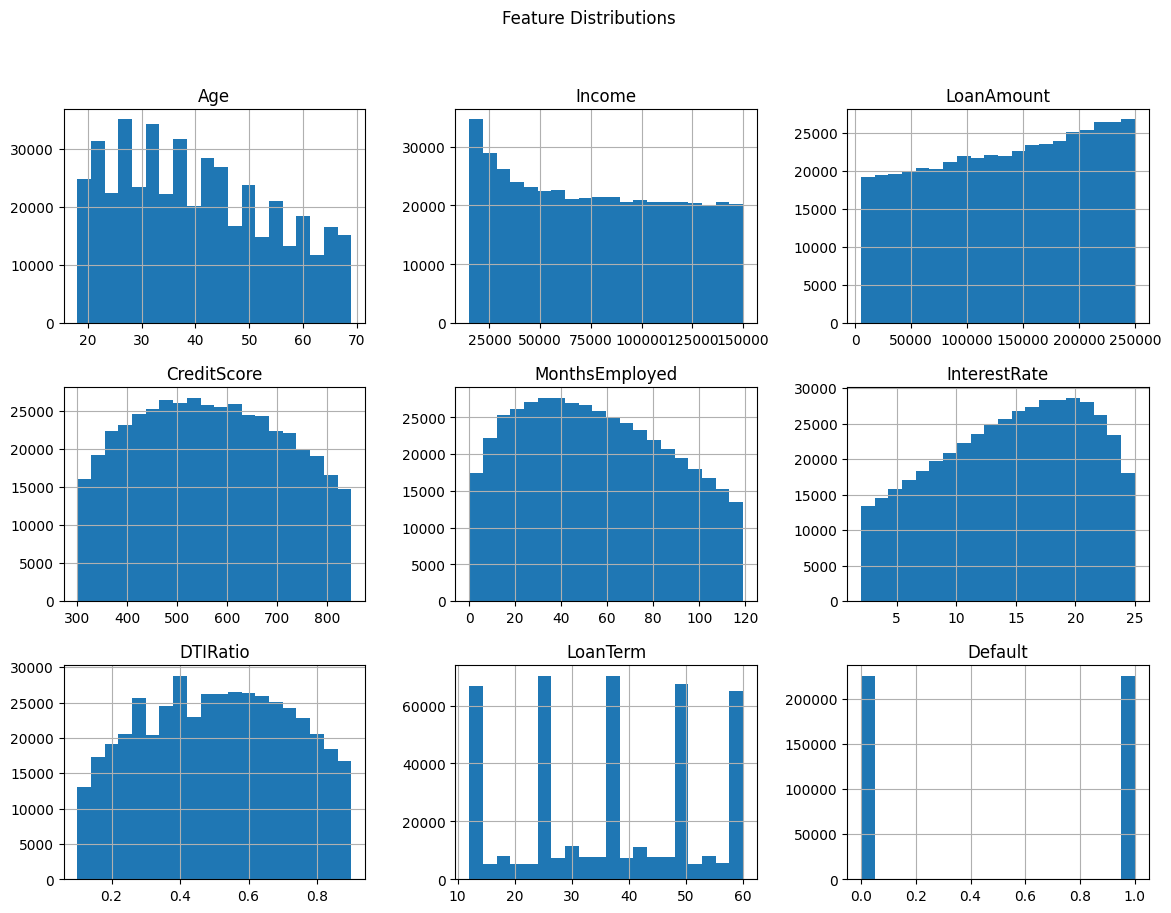

In [22]:
# Distribution of numerical features
df.hist(bins=20, figsize=(14, 10))
plt.suptitle("Feature Distributions")
plt.show()

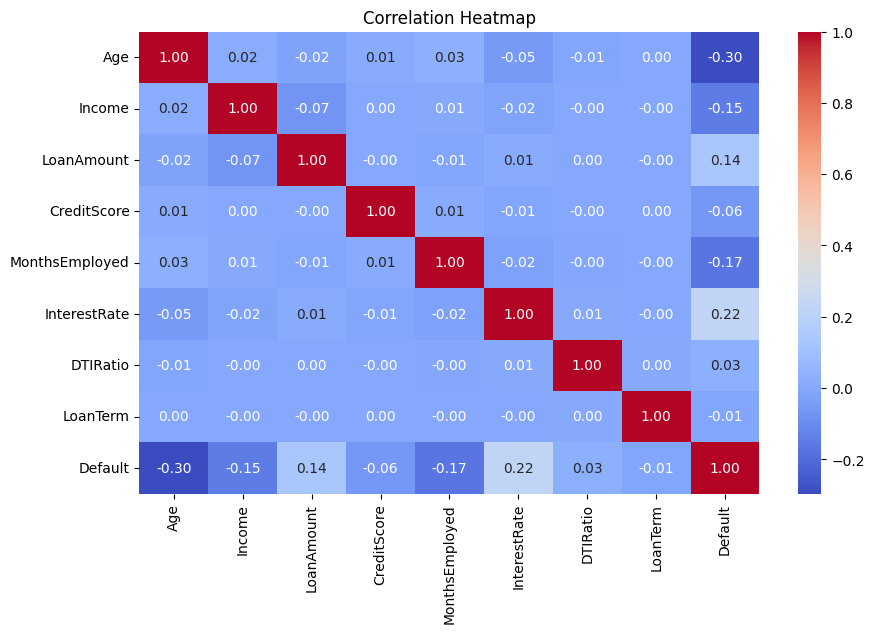

In [23]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

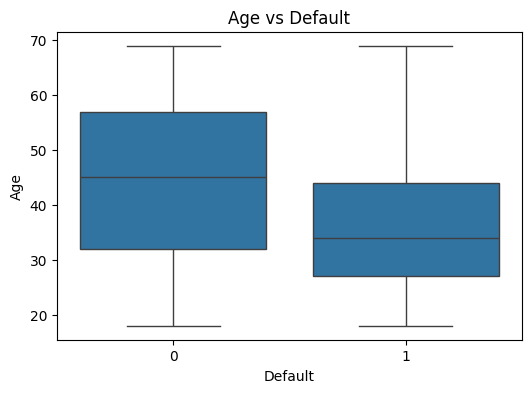

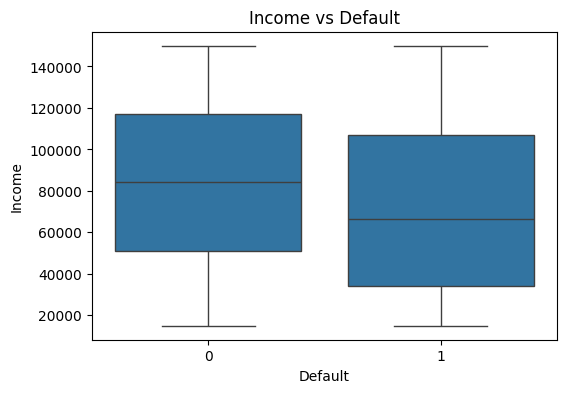

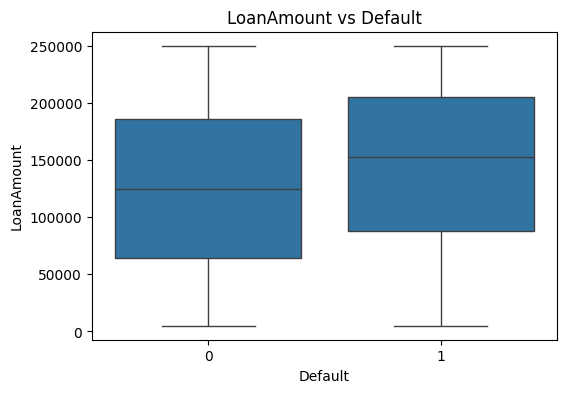

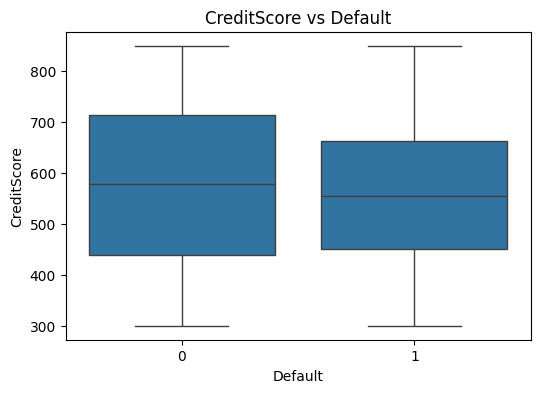

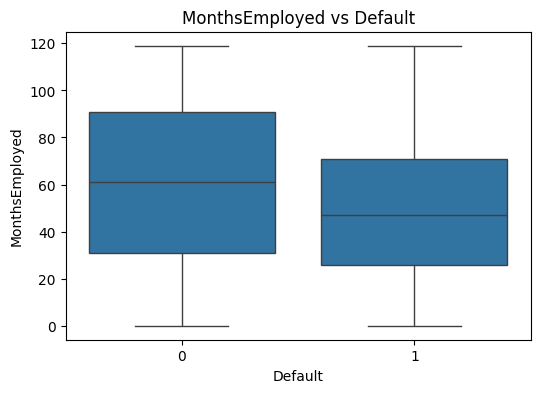

In [24]:
# Default vs Categorical/Continuous features (boxplots)
for col in ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Default", y=col, data=df)
    plt.title(f"{col} vs Default")
    plt.show()

In [25]:
df = df.dropna()

feature_cols = ['Age', 'Income', 'LoanAmount', 'CreditScore',
                'MonthsEmployed', 'InterestRate', 'DTIRatio', 'LoanTerm']
target_col = 'Default'


In [26]:
X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)


In [27]:
# STEP 2: Train Scikit-learn XGB
xgb_model = XGBClassifier(random_state=8, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train.values, y_train.values)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:47:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [28]:
# Save Model
joblib.dump(xgb_model, "loan_default_xgb_model.pkl")

['loan_default_xgb_model.pkl']

In [29]:
# Export to ONNX
initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = onnxmltools.convert_xgboost(xgb_model, initial_types=initial_type)
onnx.save_model(onnx_model, "Loan_default_prediction_model.onnx")
print("Scikit-learn model saved: .pkl and .onnx")

Scikit-learn model saved: .pkl and .onnx


In [30]:
# STEP 3: Find Best Threshold
y_probs = xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

In [31]:
# Select threshold maximizing Youden’s J (tpr - fpr)
best_thresh = thresholds[np.argmax(tpr - fpr)]
print(f"Best Threshold: {best_thresh:.4f}")

joblib.dump(best_thresh, "loan_default_threshold.pkl")


Best Threshold: 0.5070


['loan_default_threshold.pkl']

In [32]:
# STEP 4: Train Spark XGB
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from xgboost.spark import SparkXGBClassifier


In [33]:
spark = SparkSession.builder.appName("Loan_Default_Prediction_XGB").getOrCreate()
spark_df = spark.createDataFrame(df)


In [34]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
spark_df = assembler.transform(spark_df).select("features", target_col)


In [35]:
train, test = spark_df.randomSplit([0.7, 0.3], seed=42)

In [36]:
spark_xgb = SparkXGBClassifier(
    features_col="features", label_col=target_col,
    num_workers=2, max_depth=5, eta=0.1, num_round=200
)
spark_xgb_model = spark_xgb.fit(train)

INFO:XGBoost-PySpark:Running xgboost-3.0.4 on 2 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 5, 'eta': 0.1, 'num_round': 200, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


In [37]:
# Save Spark Booster as ONNX
booster = spark_xgb_model.get_booster()
booster.save_model("spark_xgb_model.json")

initial_type = [('float_input', FloatTensorType([None, len(feature_cols)]))]
onnx_model_spark = onnxmltools.convert_xgboost(booster, initial_types=initial_type)
onnx.save_model(onnx_model_spark, "loan_default_spark_xgb_model.onnx")

print("Spark XGB model saved: .onnx")

Spark XGB model saved: .onnx


In [38]:
spark.stop()